In [8]:
import pandas as pd
import numpy as np
import os
import datetime
import time
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split

#matplot lib notebooks display command
%matplotlib inline

#SET OPTIONS
pd.options.display.float_format = '{:,.2f}'.format
#GLOBAL VARIABLES
today = datetime.date.today()
cwd = os.getcwd()

In [2]:
#load dataset
non_auto_df = pd.read_csv(cwd+'\\non_automated_invoices.csv', encoding='utf-8')
non_auto_df.dtypes

Unnamed: 0                 int64
ID                        object
COURTESYSENT__C             bool
COLLECTOR                 object
OUTSOURCE_PARTNER         object
RESELLER                  object
COLLECTION_STATUS         object
HAS_TAX_EXEMP               bool
HAS_REPLACEMENT_ORDER       bool
ESCALATION_STATUS         object
COLLECTOR_FORECAST        object
BILLING_COUNTRY           object
BILLING_LANGUAGE          object
PAYMENT_TERM              object
PAYMENT_TYPE              object
SFBILL__INVOICEAGE__C      int64
HAS_30DAY_EXTXN             bool
PAST_DUE_FLG                bool
LATE_PMT                    bool
DAYS_TO_PAY                int64
CURRENCY_CODE             object
TOTAL_TAX                float64
TOTAL_AMOUNT             float64
dtype: object

In [11]:
#Normalize Numeric fields

def pre_process(df, dropcols=None):
    '''
    The pre_process function that will return a transformed dataframe
    Notes:
        1) dropcols should be a list
        2) integer varibles are transformed using mean normalization
    '''
    #drop columns input by the user
    if dropcols is not None:
        df = df.drop(columns=dropcols)
    
    #loop through remaining columns and apply the appropreate transform
    for i in df.columns:
        #mean normalization for int variables
        if df[i].dtype == "int64" or df[i].dtype == 'float64':
            mean = df[i].mean()
            if (df[i].max() - df[i].min()) == 0:
                denom = 1
            else:
                denom = (df[i].max() - df[i].min())
            df[i] = df[i].apply(lambda x: float(x - mean) / denom)
        #convert bool values to 1 and 0
        elif df[i].dtype == "bool":
            df[i] = df[i].map({True: 1, False: 0})
        #convert True and False to 1 and 0
        elif df[i].dtype == "object" and "True" in set(df[i].tolist()) and "False" in set(df[i].tolist()): 
            df[i] = df[i].map({'True': 1, 'False': 0})
        elif df[i].dtype == "object":
            df = pd.get_dummies(df, columns=[i], prefix = [i], dtype="int8") #, sparse=True
        
    return df

clean_df = pre_process(non_auto_df, dropcols=['ID','Unnamed: 0','OUTSOURCE_PARTNER'])
dtypes_df = clean_df.dtypes.to_frame('dtypes').reset_index()
dtypes_df.to_csv(cwd+'\\clean_dtypes.csv')

In [12]:
X = clean_df.loc[:, clean_df.columns != "LATE_PMT"]
y = clean_df['LATE_PMT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

Model using 1.0 as the regularization coefficient completed in 65.094sec
Model using 3.0 as the regularization coefficient completed in 135.188sec
Model using 5.0 as the regularization coefficient completed in 199.125sec
Model using 7.0 as the regularization coefficient completed in 243.5sec
Model using 9.0 as the regularization coefficient completed in 292.609sec


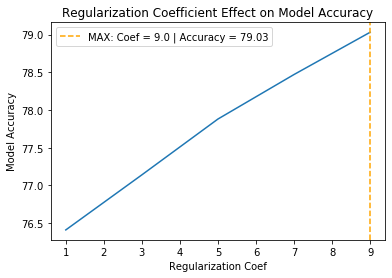

In [16]:
#logistic regression model to choose regularization coef
reg_coef_list = np.arange(1, 30.0, 5) #np.concatenate( (np.arange(0.05, 1.0, 0.05),np.arange(1, 10.0, 1)), axis=None) 
accuracy_list = []

for coef in reg_coef_list:
    start = time.process_time()
    logreg = linear_model.LogisticRegression(solver="saga", C=coef, max_iter=5000, penalty='l2')
    logreg.fit(X=X_train, y=y_train)
    score = logreg.score(X_valid, y_valid)
    accuracy_list.append(round(score*100,2))
    end = time.process_time()
    print('Model using '+str(coef)+' as the regularization coefficient completed in '+str(round(end-start,3))+'sec')

plt.plot(reg_coef_list, accuracy_list)
plt.axvline(x=reg_coef_list[accuracy_list.index(max(accuracy_list))], color='orange', linestyle='--', 
            label='MAX: Coef = {}'.format(reg_coef_list[accuracy_list.index(max(accuracy_list))])+' | Accuracy = {}'.format(max(accuracy_list)))
plt.title("Regularization Coefficient Effect on Model Accuracy")
plt.xlabel("Regularization Coef")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()